# Two-truths Phenomenon simulation
Author: Shiyu Sun, Aug. 2019


## Verify "two-truths" LSE vs. ASE spectral graph clustering phenomenon
Two-truths Phenomenon: Both ASE and LSE will lead to reasonable results, which LSE tends to capture left hemisphere/right hemisphere affinity structure and ASE tends to capture gray matter/white matter core–periphery structure.

Ref: Priebe, C. E., Park, Y., Vogelstein, J. T., Conroy, J. M., Lyzinski, V., Tang, M., ... & Bridgeford, E. (2019). On a two-truths phenomenon in spectral graph clustering. Proceedings of the National Academy of Sciences, 116(13), 5995-6000.

## Setup
- In this experiment, we use 4 block stochastic block model (SBM).
- The P matrix and component of n are according to the reference. The 4 blocks are left gray, right gray, left white, right white.

## Procedure
- Generate SBM graphs.
- Do ASE and LSE.
- Do clustering (e.g. K-means, Pyclust, mclust)

## Simulation 2
Do Pyclust, mclust, Pyclust initialized by mclust on ASE result for a bunch of times.
Plot ARI and BIC for these clustering models and make a comparison.

## Conclusion 2
- Mclust will lead to two-truths result (ASE: left/right hemishpere and LSE: gray/white matter) while Pyclust will not (both LSE and ASE: left/right hemishpere).
- Both mclust and Pyclust will arrive at convergence regions (with local minimum BIC), but their convergence values usually are different.
- Usually Pyclust will have lower BIC than mclust (Pyclust's result is better to a certain extent).

In [1]:
# TT simulation 2, clustering using R & Python

import graspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from graspy.simulations import sbm
from graspy.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed
from graspy.plot import heatmap, pairplot
from graspy.cluster.pyclust import PyclustCluster
from sklearn.metrics import adjusted_rand_score

%matplotlib inline

In [2]:
# import mclust from R and define R mclust function

## #####  rpy2 stuff  ######
# import rpy2's package module
import rpy2.robjects.packages as rpackages
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
packnames = ('mclust')
utils = rpackages.importr('utils')
base = rpackages.importr('base')
utils.chooseCRANmirror(ind=1) # select the first mirror in the list
from rpy2.robjects.vectors import StrVector
utils.install_packages(StrVector(packnames))
mclust = rpackages.importr('mclust',lib_loc ="D:/Program Files/R/R-3.6.1/library")

## new def for R's mclust

def cluster_R(E,label):
    nr,nc = E.shape
    Er = robjects.r.matrix(E, nrow=nr, ncol=nc)
    robjects.r.assign("E", Er)
    mc = mclust.Mclust(Er, G=2, verbose=0)
    Y = mc.rx2("classification")
    classification = np.array(Y, dtype=np.uint8) - 1 
    bic = np.mat(mc.rx2("bic"))
    bic = - bic 
    ari = adjusted_rand_score(label, classification)
    results = pd.DataFrame({"classification":[classification],"bic":[bic],"ari":[ari] })
    return results

In [3]:
# define pyclust function
def cluster_pyclust(X, label):
    py_ase = PyclustCluster(max_components=2).fit(X,y=label)
    ase_py = py_ase.predict(X)
    ari = adjusted_rand_score(label, ase_py)
    results = pd.DataFrame({"classification":[ase_py],"bic":[py_ase.bic_],"ari":[ari] })
    return results

# define pyclust initialized by mclust function
def cluster_Rpyclust(X, label, label_init):
    py_ase = PyclustCluster(max_components=2,label_init=label_init).fit(X)
    ase_py = py_ase.predict(X)
    ari = adjusted_rand_score(label, ase_py)
    results = pd.DataFrame({"classification":[ase_py],"bic":[py_ase.bic_],"ari":[ari] })
    return results

In [4]:
# setup
np.random.seed(3000)
n_verts = 800
labels_sbm = int(0.28 * n_verts) * ["LG"] + int(0.22 * n_verts) * ["LW"] + int(0.28 * n_verts) * ["RG"] + int(0.22 * n_verts) * ["RW"]
labels_lr = int(0.28 * n_verts) * [0] + int(0.22*n_verts) * [0] + int(0.28*n_verts) * [1] + int(0.22*n_verts) * [1] #true label
labels_gw = int(0.28 * n_verts) * [0] + int(0.22*n_verts) * [1] + int(0.28*n_verts) * [0] + int(0.22*n_verts) * [1] #true label
n_verts = int(0.28 * n_verts) + int(0.22*n_verts) + int(0.28*n_verts) + int(0.22*n_verts)

P = np.array([[0.020, 0.044, 0.002, 0.009],
              [0.044, 0.115, 0.010, 0.042],
              [0.002, 0.010, 0.020, 0.045],
              [0.009, 0.042, 0.045, 0.117]])
times=100

In [5]:
# main processing
R_results = pd.DataFrame(columns=["classification","bic","ari"] )
pyclust_results = pd.DataFrame(columns=["classification","bic","ari"] )
Rpyclust_results = pd.DataFrame(columns=["classification","bic","ari"] )
for i in range(times):
    undirected_sbm = sbm([int(0.28 *n_verts),int(0.22 *n_verts),int(0.28 *n_verts),int(0.22 *n_verts)], P)
    ase = AdjacencySpectralEmbed()
    ase_Xhat = ase.fit_transform(undirected_sbm)
    R_entry= cluster_R(ase_Xhat,labels_gw)
    R_results = R_results.append(R_entry,ignore_index=True,sort=False)
    pyclust_results = pyclust_results.append(cluster_pyclust(ase_Xhat,labels_gw),ignore_index=True,sort=False)
    Rpyclust_results = Rpyclust_results.append(cluster_Rpyclust(ase_Xhat,labels_gw,R_entry.loc[0,"classification"]),ignore_index=True,sort=False)

## ARI
As ARI figures below, Pyclust usually get left/right hemisphere (ARI of most points approximates 0) and mclust usually get gray/white matter (ARI of most points approximates 1). If initialize Pyclust using mclust result, the model will stay at the initial state (ARI approximates 1).

(-0.1, 1)

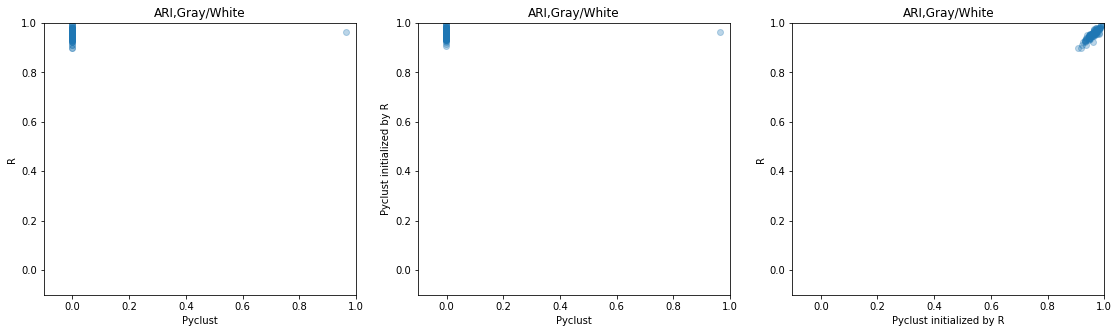

In [8]:
# ARI
ari=np.zeros([times,3])
for i in range(times):
    ari[i,0] = R_results.loc[i,"ari"]
    ari[i,1] = pyclust_results.loc[i,"ari"]
    ari[i,2] = Rpyclust_results.loc[i,"ari"]

plt.figure(figsize=(19,5))

plt.subplot(131)
plt.scatter(ari[:,1], ari[:,0], alpha=0.3)
plt.title("ARI,Gray/White")
plt.xlabel("Pyclust");plt.ylabel("R")
plt.xlim(-0.1,1)
plt.ylim(-0.1,1)

plt.subplot(132)
plt.scatter(ari[:,1], ari[:,2], alpha=0.3)
plt.title("ARI,Gray/White")
plt.xlabel("Pyclust");plt.ylabel("Pyclust initialized by R")
plt.xlim(-0.1,1)
plt.ylim(-0.1,1)

plt.subplot(133)
plt.scatter(ari[:,2], ari[:,0], alpha=0.3)
plt.title("ARI,Gray/White")
plt.xlabel("Pyclust initialized by R");plt.ylabel("R")
plt.xlim(-0.1,1)
plt.ylim(-0.1,1)

## BIC
As for BIC, the lower, the better. The figures below show that Pyclust has lower BIC than mclust for most of the graphs, which suggests that Pyclust may be a better choice. Besides, BIC of mclust and Pyclust initialized by mclust are approximately equal.

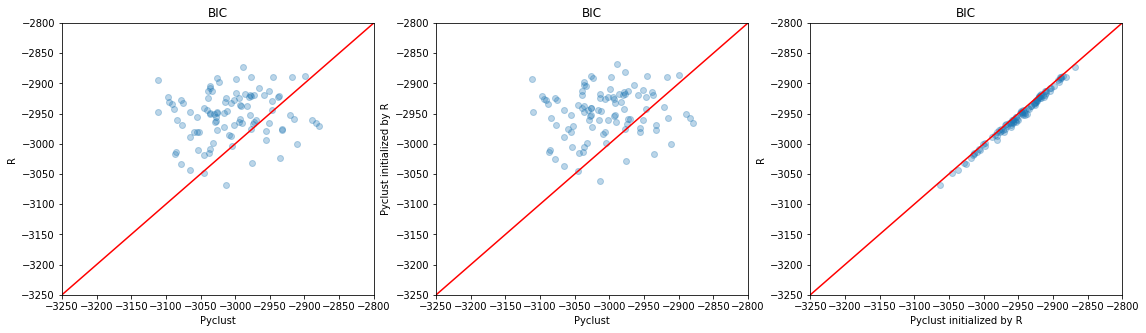

In [7]:
# BIC
bic=np.zeros([times,3])
for i in range(times):
    bic[i,0] = R_results.loc[i,"bic"]
    bic[i,1] = pyclust_results.loc[i,"bic"]
    bic[i,2] = Rpyclust_results.loc[i,"bic"]
    
x = np.arange(-3250,-2800, 0.5) 
y = x 

plt.figure(figsize=(19,5))
plt.subplot(131)
plt.scatter(bic[:,1], bic[:,0], alpha=0.3)
plt.title("BIC")
plt.xlabel("Pyclust");plt.ylabel("R")
plt.xlim(-3250,-2800);plt.ylim(-3250,-2800)
plt.plot(x, y,'r')

plt.subplot(132)
plt.scatter(bic[:,1], bic[:,2], alpha=0.3)
plt.title("BIC")
plt.xlabel("Pyclust");plt.ylabel("Pyclust initialized by R")
plt.xlim(-3250,-2800);plt.ylim(-3250,-2800)
plt.plot(x, y,'r')

plt.subplot(133)
plt.scatter(bic[:,2], bic[:,0], alpha=0.3)
plt.title("BIC")
plt.xlabel("Pyclust initialized by R");plt.ylabel("R")
plt.xlim(-3250,-2800);plt.ylim(-3250,-2800)
plt.plot(x, y,'r')